In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [226]:
import pathlib
import cv2
import dlib
import math

In [227]:
cascade_path = "haarcascade_frontalface_default.xml"
predictor_path = "shape_predictor_68_face_landmarks.dat"

faceCascade = cv2.CascadeClassifier(cascade_path)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

In [228]:
def get_lum(image, x, y, w, h, k):


    i1 = range(int(-w / 2), int(w / 2))
    j1 = range(0, h)

    lumar = np.zeros((len(i1), len(j1)))
    for i in i1:
        for j in j1:
            if y + k * h < 0 or y + k * h >= image.shape[0]:
                lumar[i][j] = None
            else:
                lum = np.min(np.clip(image[y + k * h, x + i], 0, 255))
                lumar[i][j] = lum

    return np.min(lumar)

def q(landmarks, index1, index2):

    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]

    x_diff = float(x1 - x2)


    if y1 < y2: y_diff = float(np.absolute(y1 - y2))
    if y1 >= y2:
        y_diff = 0.1

    return np.absolute(math.atan(x_diff / y_diff))


def d(landmarks, index1, index2):
    # get distance between i1 and i2

    x1 = landmarks[int(index1)][0]
    y1 = landmarks[int(index1)][1]
    x2 = landmarks[int(index2)][0]
    y2 = landmarks[int(index2)][1]

    x_diff = (x1 - x2) ** 2
    y_diff = (y1 - y2) ** 2

    dist = math.sqrt(x_diff + y_diff)

    return dist

In [229]:
dirs = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']

imagedir = "FaceShapeDatasetProcessingInput/training_set"
sub_dir = [q for q in pathlib.Path(imagedir).iterdir() if q.is_dir()][1:]
train_features = []

In [230]:
for i in range(len(sub_dir)):
    images_dir = [p for p in pathlib.Path(sub_dir[i]).iterdir() if p.is_file()]
    for j in range(len(images_dir)):
        img_i = cv2.imread(str(images_dir[j]))
        img_gray = cv2.cvtColor(img_i, cv2.COLOR_BGR2GRAY)
        img_eq = cv2.equalizeHist(img_gray)
        img = cv2.resize(img_eq, (500, 600))
        
#         cv2.imshow("Image", img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         string = pathlib.Path(images_dir[j]).name
#         print(string)
        
        mn = 14
        faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100), flags=cv2.CASCADE_SCALE_IMAGE)
        
        detector_flag = False
        flag2 = 0
        
        x, y, w, h = 0, 0, 0, 0
        while len(faces) != 1:
            prev_mn = mn
            if len(faces) == 0:
                faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100),
                                                     flags=cv2.CASCADE_SCALE_IMAGE)
                mn -= 1
                if mn == 0 and len(faces) == 0:
                    faces = detector(img)
                    detector_flag = True
                    if len(faces) == 0:
                        x = 10
                        y = 10
                        w = img.shape[1] - 10
                        h = img.shape[0] - 10
                        detector_flag = False
                    break
            else:
                faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100),
                                                     flags=cv2.CASCADE_SCALE_IMAGE)
                mn += 1

            if prev_mn < mn:
                flag2 = 1
                break

        if mn == 0 and detector_flag is True:
            face = faces[flag2]
            x, y = face.left(), face.top()
            w, h = face.right() - x, face.bottom() - y
        elif len(faces) != 0 and mn >= 0:
            face = faces[flag2]
            x, y, w, h = face

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
#         cv2.imshow("Image", img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        
#         cv2.imshow("Detected Faces", img)
#         if cv2.waitKey(100) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        dlib_rect = dlib.rectangle(int(0.8 * x), int(0.8 * y), int(x + 1.05*w), int(y + 1.1*h))

        detected_landmarks = predictor(img, dlib_rect).parts()

        landmarks = np.matrix([[p.x, p.y] for p in detected_landmarks])
        
        img_copy = img.copy()

#         for idx, point in enumerate(landmarks):
#             print(point[0, 0], point[0, 1])
#             pos = (point[0, 0], point[0, 1])
#             cv2.circle(img_copy, pos, 5, color=(255, 0, 0), thickness=2)
            
#         cv2.imshow("Images_with_Landmarks", img_copy)
#         if cv2.waitKey(25) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        p27 = (landmarks[27][0, 0], landmarks[27][0, 1])
        x = p27[0]
        y = p27[1]

        diff = get_lum(img, x, y, 8, 2, -1)
        limit = diff - 55

        while diff > limit:
            y = int(y - 1)
            diff = get_lum(img, x, y, 6, 2, -1)

#         cv2.circle(img_copy, (x, y), 5, color=(0, 0, 255), thickness=2)
        
#         cv2.imshow("Images_with_Landmarks", img_copy)
#         if cv2.waitKey(100) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        lmark = landmarks.tolist()
        p68 = (x, y)
        lmark.append(p68)

        f = []
        f.append(dirs[i])

        fwidth = d(lmark, 0, 16)
        fheight = d(lmark, 8, 68)
        f.append(fheight / fwidth)

        jwidth = d(lmark, 4, 12)
        f.append(jwidth / fwidth)

        hchinmouth = d(lmark, 57, 8)
        f.append(hchinmouth / fwidth)
        ref = q(lmark, 27, 8)

        for k in range(0, 17):
            if k != 8:
                theta = q(lmark, k, 8)
                f.append(theta)

        for k in range(1, 8):
            dist = d(lmark, k, 16-k)
            f.append(dist/fwidth)

        train_features.append(f)

In [231]:
imagedir = "FaceShapeDatasetProcessingInput/testing_set"
sub_dir = [q for q in pathlib.Path(imagedir).iterdir() if q.is_dir()]
test_features = []

In [232]:
for i in range(len(sub_dir)):
    images_dir = [p for p in pathlib.Path(sub_dir[i]).iterdir() if p.is_file()]
    for j in range(len(images_dir)):
        img_i = cv2.imread(str(images_dir[j]))
        img_gray = cv2.cvtColor(img_i, cv2.COLOR_BGR2GRAY)
        img_eq = cv2.equalizeHist(img_gray)
        img = cv2.resize(img_eq, (500, 600))
        
#         cv2.imshow("Image", img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         string = pathlib.Path(images_dir[j]).name
#         print(string)
        
        mn = 14
        faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100), flags=cv2.CASCADE_SCALE_IMAGE)
        
        detector_flag = False
        flag2 = 0
        
        x, y, w, h = 0, 0, 0, 0
        while len(faces) != 1:
            prev_mn = mn
            if len(faces) == 0:
                faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100),
                                                     flags=cv2.CASCADE_SCALE_IMAGE)
                mn -= 1
                if mn == 0 and len(faces) == 0:
                    faces = detector(img)
                    detector_flag = True
                    if len(faces) == 0:
                        x = 10
                        y = 10
                        w = img.shape[1] - 10
                        h = img.shape[0] - 10
                        detector_flag = False
                    break
            else:
                faces = faceCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=mn, minSize=(100, 100),
                                                     flags=cv2.CASCADE_SCALE_IMAGE)
                mn += 1

            if prev_mn < mn:
                flag2 = 1
                break

        if mn == 0 and detector_flag is True:
            face = faces[flag2]
            x, y = face.left(), face.top()
            w, h = face.right() - x, face.bottom() - y
        elif len(faces) != 0 and mn >= 0:
            face = faces[flag2]
            x, y, w, h = face

        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
#         cv2.imshow("Image", img)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        
#         cv2.imshow("Detected Faces", img)
#         if cv2.waitKey(100) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        dlib_rect = dlib.rectangle(int(0.8 * x), int(0.8 * y), int(x + 1.05*w), int(y + 1.1*h))

        detected_landmarks = predictor(img, dlib_rect).parts()

        landmarks = np.matrix([[p.x, p.y] for p in detected_landmarks])
        
        img_copy = img.copy()

#         for idx, point in enumerate(landmarks):
#             print(point[0, 0], point[0, 1])
#             pos = (point[0, 0], point[0, 1])
#             cv2.circle(img_copy, pos, 5, color=(255, 0, 0), thickness=2)
            
#         cv2.imshow("Images_with_Landmarks", img_copy)
#         if cv2.waitKey(25) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        p27 = (landmarks[27][0, 0], landmarks[27][0, 1])
        x = p27[0]
        y = p27[1]

        diff = get_lum(img, x, y, 8, 2, -1)
        limit = diff - 55

        while diff > limit:
            y = int(y - 1)
            diff = get_lum(img, x, y, 6, 2, -1)

#         cv2.circle(img_copy, (x, y), 5, color=(0, 0, 255), thickness=2)
        
#         cv2.imshow("Images_with_Landmarks", img_copy)
#         if cv2.waitKey(100) & 0XFF == 27:
#             break
#         cv2.destroyAllWindows()

        lmark = landmarks.tolist()
        p68 = (x, y)
        lmark.append(p68)

        f = []
        f.append(dirs[i])

        fwidth = d(lmark, 0, 16)
        fheight = d(lmark, 8, 68)
        f.append(fheight / fwidth)

        jwidth = d(lmark, 4, 12)
        f.append(jwidth / fwidth)

        hchinmouth = d(lmark, 57, 8)
        f.append(hchinmouth / fwidth)
        ref = q(lmark, 27, 8)

        for k in range(0, 17):
            if k != 8:
                theta = q(lmark, k, 8)
                f.append(theta)

        for k in range(1, 8):
            dist = d(lmark, k, 16-k)
            f.append(dist/fwidth)

        test_features.append(f)

In [233]:
train_x = [feature[1:] for feature in train_features]
test_x = [feature[1:] for feature in test_features]
train_y = [feature[0] for feature in train_features]
test_y = [feature[0] for feature in test_features]

In [234]:
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from sklearn.naive_bayes import MultinomialNB

In [235]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [236]:
pca = PCA(n_components=2)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

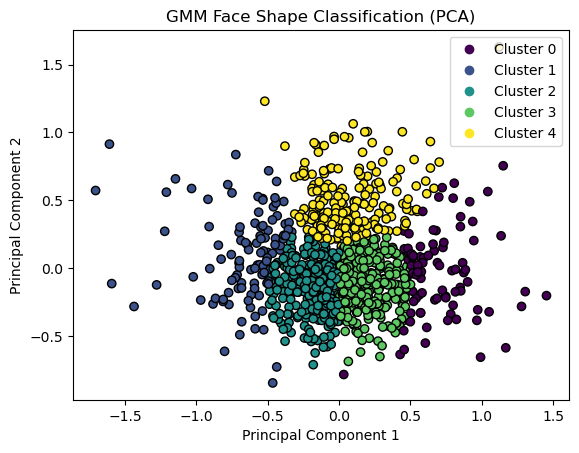

In [237]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(train_x)

pred_y = gmm.predict(test_x)
scatter = plt.scatter(test_x[:, 0], test_x[:, 1], c=pred_y, cmap='viridis', marker='o', edgecolors='k')
legend = [f'Cluster {i}' for i in range(5)]
plt.legend(handles=scatter.legend_elements()[0], labels=legend)
plt.title('GMM Face Shape Classification (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [238]:
classes = {0: '4', 1: '3', 2: '1', 3: '2', 4: '0'}

In [239]:
py = [classes[x] for x in pred_y]

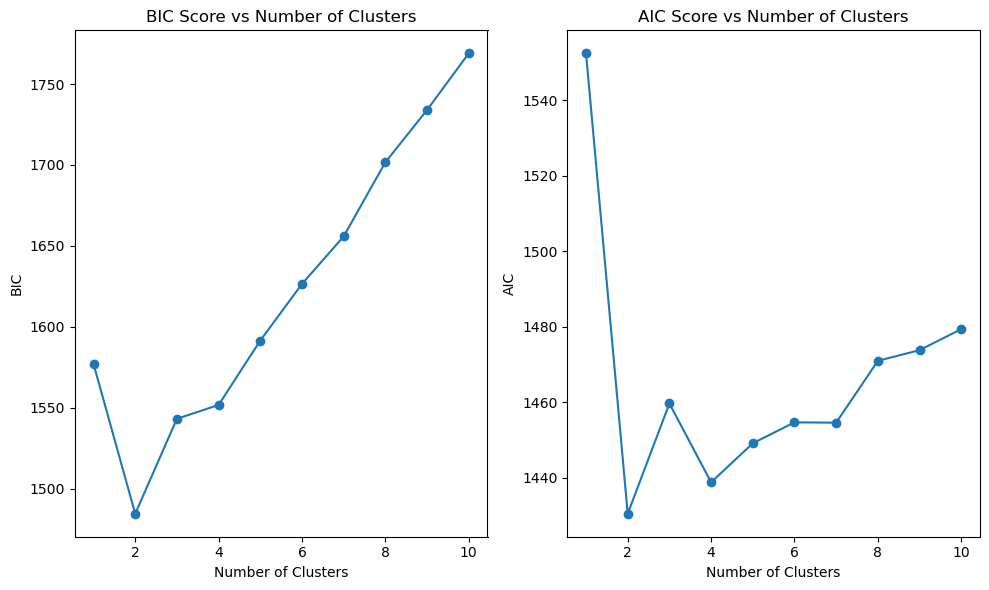

In [240]:
bic_scores = []
aic_scores = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k)
    gmm.fit(test_x)
    bic_scores.append(gmm.bic(test_x))
    aic_scores.append(gmm.aic(test_x))

# Plotting BIC and AIC scores against number of clusters
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, 11), bic_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')
plt.title('BIC Score vs Number of Clusters')

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), aic_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')
plt.title('AIC Score vs Number of Clusters')

plt.tight_layout()
plt.show()

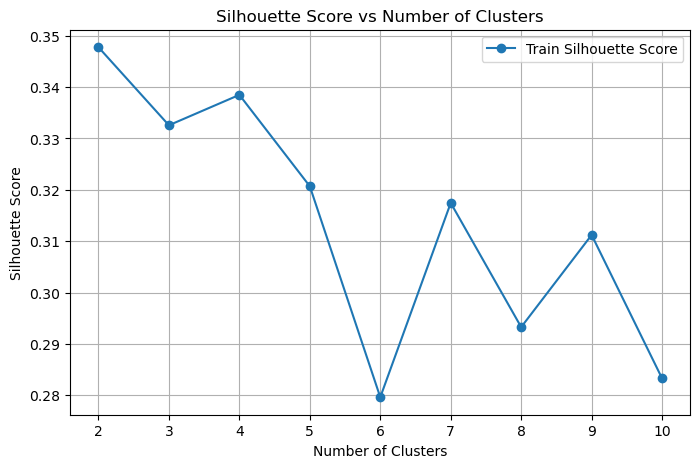

In [241]:
silhouette_scores_train = []
num_clusters_range = range(2, 11)  # Choose a range of clusters to explore

for k in num_clusters_range:
    gmm = GaussianMixture(n_components=k)
    gmm.fit(test_x)
    
    train_image_cluster_labels = gmm.predict(test_x)
    silhouette_train = silhouette_score(test_x, train_image_cluster_labels)
    silhouette_scores_train.append(silhouette_train)
    

# Plotting silhouette scores against number of clusters
plt.figure(figsize=(8, 5))

plt.plot(num_clusters_range, silhouette_scores_train, marker='o', label='Train Silhouette Score')

plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

In [242]:
import joblib
joblib.dump(gmm, 'gmm_pickle.pkl')

['gmm_pickle.pkl']